In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as ss

In [3]:
# load your data (don't touch, just run)

"""
data = []
f = open('covtype.data','r')
while(1):
    line = f.readline()
    if  len(line) < 100:
        print line
    
    if len(line) == 0: break
    data.append(np.array([float(k) for k in line.split(',')]))
    if len(data) % 100000 == 0:
        print len(data)
        
f.close
data = np.vstack(data)
N = data.shape[0]
idx = np.random.permutation(N)


X_test = data[:N/5,:]
X_train = data[N/5:,:]
y_test = X_test[:,-1]
y_train = X_train[:,-1]
X_test = X_test[:,:-1]
X_train = X_train[:,:-1]


sio.savemat('covtype.mat',{'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test})
data = sio.loadmat('covtype.mat')
X_train = data['X_train'][:100,:]
X_test = data['X_test'][:100,:]
y_train = data['y_train'][0][:100]
y_test = data['y_test'][0][:100]
print X_train.shape, X_test.shape, y_train.shape, y_test.shape
sio.savemat('covtype_reduced.mat',{'X_train':X_train,'X_test':X_test,'y_train':y_train,'y_test':y_test})
"""



data = sio.loadmat('covtype_reduced.mat')
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train'][0][:]
y_test = data['y_test'][0][:]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(468, 54) (116202, 54) (468,) (116202,)


In [6]:
def entropy(y):
    m = len(y)
    K = len(set(y))
   
    if m == 1: return 0.
    
    total_term = 0.
    for k in range(K):
        p = sum(np.equal(y,k))/(m+0.)
        term = p*np.log2(p) if p > 0. else 0.
        total_term -= term
        
    return total_term

def cond_entropy(y,yhat):
    m = len(y)
    K = len(set(y))
    Khat = len(set(yhat))
    if m == 1: 
        return 0.
    
    total_term = 0.
    for i in range(K):
        if sum(np.equal(y,i)) == 0.:
            continue
        u = np.equal(y,i)
        for j in range(Khat):
            if sum(np.equal(yhat,j)) == 0.:
                continue
            v = np.equal(yhat,j)
            uv = np.logical_and(u,v)
            if sum(uv) == 0: 
                continue
            pugv = np.sum(uv)/(np.sum(v)+0.)
            puv = np.sum(uv)/ (m+0.) 
            
            term = puv*np.log2(pugv)
            total_term -= term
    return total_term

#random_sequence_1 = (np.random.rand(1000)*10).astype(int)
#random_sequence_2 = (np.random.rand(1000)*2).astype(int)
#sio.savemat('random_sequences.mat',{'s1':random_sequence_1,'s2':random_sequence_2})

random_sequences = sio.loadmat('random_sequences.mat')

s1 = random_sequences['s1'][0]
s2 = random_sequences['s2'][0]

print('entropy = ', entropy(s1))
print('conditional entropy = ', cond_entropy(s1,s2))


entropy =  3.314182323161083
conditional entropy =  3.3029598816135173


In [9]:
def find_best_split(x,y):
    discretize = 10
    nfeat = x.shape[1]
    score = np.zeros((discretize,nfeat))
    
    best_split = np.zeros(nfeat)
    best_score = np.zeros(nfeat)
    for feat in range(nfeat):
        splitrange = np.linspace(min(x[:,feat]),max(x[:,feat]),discretize)
        score = splitrange * 0.
        for i in range(len(splitrange)):
            s = splitrange[i]
            yhat = np.less(x[:,feat] ,s)
            score[i] = entropy(y) - cond_entropy(y,yhat)

        best_split_idx = np.argmax(score)
        best_split[feat] = splitrange[best_split_idx]
        best_score[feat] = score[best_split_idx]
    best_feat = np.argmax(best_score)
    splitval = best_split[best_feat]
    
    set1 = np.where(np.less(x[:,best_feat],splitval))[0]
    set2 = np.where(np.greater_equal(x[:,best_feat],splitval))[0]
    if min(len(set1), len(set2)) == 0:
        return None, None, None, None
    return best_feat, splitval, set1, set2


best_feat, splitval, set1, set2 = find_best_split(X_train, y_train)
y_new = y_train * 0
y_new[set1] = 1
print('information gained in first step', entropy(y_train) - cond_entropy(y_train,y_new))

information gained in first step 0.3194893606666638


In [36]:
def purity(y):
    return ss.mode(y)[1][0]/(len(y)+0.)
    

class Node:
    def __init__(self,  sample_idx, nodeid,  is_leaf = True):
        self.is_leaf = is_leaf
        self.id = nodeid
        self.sample_idx = sample_idx
        self.children = []
        self.splitable = True
        
        
    def visit_node(self, x):
        if self.is_leaf:
            return self.label
        decision = self.split_rule(x)
        return self.children[decision].visit_node(x)
        
    def split_rule(self,x):
        return 0 if x[self.splitfeat] < self.splitval else 1
            
    
    def add_split_details(self, splitfeat, splitval)  :
        self.splitfeat = splitfeat
        self.splitval = splitval
        
        
        
class Tree:
    def __init__(self, x,y):
        m = len(y)
        self.x = x
        self.y = y
        self.maxid = -1
        self.root = self.construct_node(np.array(range(m)))
        self.leaves = [self.root]
        
    def print_tree(self):
        print('printing tree...')
        def print_node(parent, node):
            print(node.id, end='')
            
            if parent is not None:
                print(', parent ', parent.id,end='')
            else:
                print(', ROOT',end='')
                
            print(', label ', node.label, end='')
            if node.is_leaf: 
                print(', LEAF, ', 'nsamples %d, purity %.2f' %(len(node.sample_idx), purity(self.y[node.sample_idx])))
            else:
                print(', NONLEAF, split %d, val %.2f' % (node.splitfeat, node.splitval))
            if not node.is_leaf:
                for ch in node.children:
                    print_node(node, ch)
        print_node(None, self.root)
    def construct_node(self, sample_idx):
        node = Node(sample_idx, self.maxid + 1,  True)
      
        node.label = ss.mode(self.y[sample_idx])[0][0]
        node.entropy = entropy(self.y[sample_idx])
        
        node.num_mistakes = np.sum(np.not_equal(node.label, self.y[sample_idx]))
        self.maxid += 1
        return node
        


    def report_train_err(self):
        total_mistakes = 0
        for leaf in self.leaves:
            total_mistakes += leaf.num_mistakes
        return total_mistakes / (len(self.y)+0.)
        
    def update_leaf(self, which_leaf):
        leaf = self.leaves[which_leaf]
        splitfeat, splitval,set1,set2 = find_best_split(self.x[leaf.sample_idx,:],self.y[leaf.sample_idx])
        if splitfeat is None:
            leaf.splitable = False
            return None, None
        leaf.add_split_details(splitfeat, splitval)
        leaf.is_leaf = False
    
        set1 = leaf.sample_idx[set1]
        set2 = leaf.sample_idx[set2]
     
        leaf.children.append(self.construct_node(set1))
        leaf.children.append(self.construct_node(set2))
        
        self.leaves.pop(which_leaf)
        self.leaves.extend(leaf.children)

        return splitfeat, splitval
    
    def report_worst_leaf(self):
        worst_leaf_score = -np.inf
        worst_leaf = None
        for l in range(len(self.leaves)):
            leaf = self.leaves[l]
            if leaf.splitable:
                leaf_score = leaf.entropy
                if leaf_score > worst_leaf_score:
                    worst_leaf = l
                    worst_leaf_score = leaf_score
        return worst_leaf
        
    
    def predict(self,x):
        return self.root.visit_node(x)


    

In [37]:
def get_test_err(tree):
    # get test error
    num_test_mistakes = 0
    for k in range(len(y_test)):
        x,y = X_test[k,:],y_test[k]
        if y != tree.predict(x):
            num_test_mistakes += 1
    return num_test_mistakes / (len(y_test)+0.)



tree = Tree(X_train,y_train)
tree.print_tree()
print('current train err:', tree.report_train_err())
print('current test err:', get_test_err(tree))


# my first split
best_feat, splitval, set1, set2 = find_best_split(X_train, y_train)
 
left_child = tree.construct_node(set1)
right_child = tree.construct_node(set2)
tree.root.is_leaf = False
tree.leaves.pop(tree.leaves.index(tree.root))
tree.root.add_split_details(splitfeat = best_feat, splitval = splitval)


tree.root.children = [left_child, right_child]
tree.leaves.extend(tree.root.children)
tree.print_tree()
print('one step train err:', tree.report_train_err())
print('one step test err:', get_test_err(tree))





printing tree...
0, ROOT, label  2.0, LEAF,  nsamples 468, purity 0.44
current train err: 0.5641025641025641
current test err: 0.3138069912738163
printing tree...
0, ROOT, label  2.0, NONLEAF, split 0, val 2852.11
1, parent  0, label  2.0, LEAF,  nsamples 119, purity 0.46
2, parent  0, label  1.0, LEAF,  nsamples 349, purity 0.51
one step train err: 0.5
one step test err: 0.486463227827404


In [38]:


misclass_train = []
misclass_test = []
tree = Tree(X_train,y_train)
misclass_train.append(tree.report_train_err())
misclass_test.append(get_test_err(tree))


for iter in range(25):
    print('iter', iter)
    split = None
    while split is None:
        next_split = tree.report_worst_leaf()
        if next_split is None: 
            print('terminated')
            break
        split, val = tree.update_leaf(next_split)
    
    if next_split is None: 
        print('terminated')
        break
        
    misclass_train.append(tree.report_train_err())
    misclass_test.append(get_test_err(tree))



iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9
iter 10
iter 11
iter 12
iter 13
iter 14
iter 15
iter 16
iter 17
iter 18
iter 19
iter 20
iter 21
iter 22
iter 23
iter 24


printing tree...
0, ROOT, label  2.0, NONLEAF, split 0, val 2852.11
1, parent  0, label  2.0, NONLEAF, split 0, val 2498.78
3, parent  1, label  3.0, LEAF,  nsamples 35, purity 0.63
4, parent  1, label  2.0, NONLEAF, split 0, val 2667.89
5, parent  4, label  2.0, NONLEAF, split 17, val 0.11
7, parent  5, label  2.0, NONLEAF, split 9, val 2366.44
9, parent  7, label  2.0, NONLEAF, split 4, val 75.00
13, parent  9, label  2.0, NONLEAF, split 4, val -10.00
33, parent  13, label  1.0, LEAF,  nsamples 1, purity 1.00
34, parent  13, label  2.0, LEAF,  nsamples 19, purity 0.84
14, parent  9, label  3.0, LEAF,  nsamples 4, purity 0.50
10, parent  7, label  3.0, LEAF,  nsamples 3, purity 0.67
8, parent  5, label  3.0, LEAF,  nsamples 4, purity 1.00
6, parent  4, label  2.0, NONLEAF, split 2, val 15.67
17, parent  6, label  2.0, NONLEAF, split 6, val 234.67
19, parent  17, label  2.0, NONLEAF, split 5, val 2428.00
21, parent  19, label  2.0, NONLEAF, split 33, val 0.11
35, parent  21, label  2.0

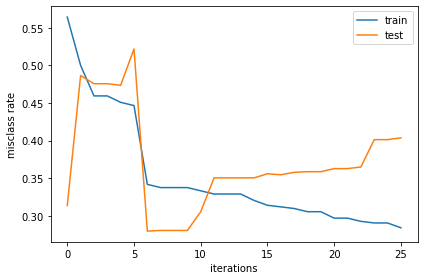

In [39]:

tree.print_tree()
plt.plot(misclass_train)
plt.plot(misclass_test)
plt.xlabel('iterations')
plt.ylabel('misclass rate')
plt.legend(['train','test'])
plt.tight_layout()
plt.savefig('decision_tree_covertype.png')